# Simple Audio Processing

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile as wav
import wave

## File input

In [62]:
def wav_read(filename):
    """Return 1D NumPy array of wave-formatted audio data denoted by filename.
    
    Input should be a string containing the path to a wave-formatted audio file.
    File should be uncompressed 16-bit."""
    sample_rate, data_2d = wav.read(filename)
    data_1d = [val for val, _ in data_2d]
    return np.array(data_1d)

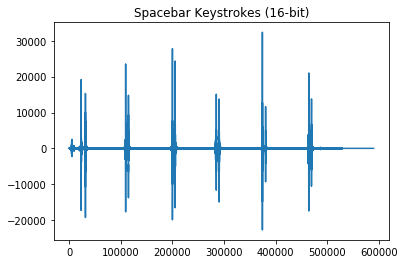

In [64]:
sound_file = 'datasets/spacebar-6x-16bit.wav'
spacebar_6x = wav_read(sound_file)

%matplotlib inline
plt.title('Spacebar Keystrokes (16-bit)')
plt.plot(spacebar_6x)
plt.show()

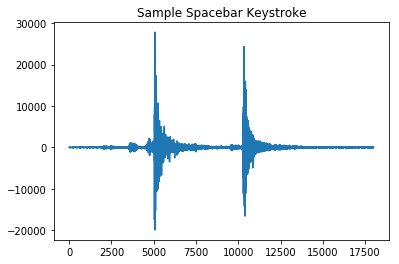

In [65]:
sample_keystroke = spacebar_6x[195000:213000]
plt.title('Sample Spacebar Keystroke')
plt.plot(sample_keystroke)
plt.show()

## Keystroke extraction

### Calculating Silence Threshold

In [69]:
def stats(array):
    """Return a dictionary containing relevant statistical data.
    
    :type array -- NumPy array
    :rtype dict
    """
    return {
        "length": len(array),
        "mean": np.mean(array),
        "median": np.median(array),
        "max": np.amax(array),
        "min": np.amin(array),
        "std deviation": np.std(array),
    }

#### Test 1 - Silence followed by 1 keystroke

length = 300000
mean = -0.46442333333333335
median = 0.0
max = 104
min = -104
std deviation = 22.414488044583774


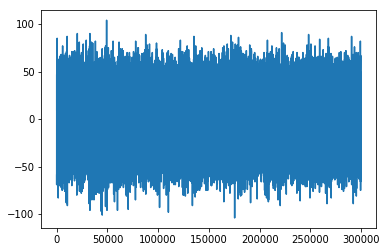

In [85]:
silence1_raw = wav_read('datasets/spacebar-1x-withsilence.wav')
silence1 = silence_raw[:300000]

silence1_stats = stats(silence1)
for stat in silence1_stats:
    print(f'{stat} = {silence1_stats[stat]}')
    
plt.plot(silence1)
plt.show()

#### Test 2 - Silence followed by several keystrokes (same key, consistent pace)

length = 600000
mean = -0.46246
median = 0.0
max = 116
min = -121
std deviation = 24.353047531710143


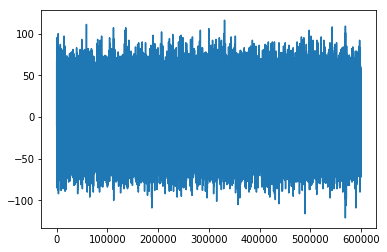

In [123]:
silence2_raw = wav_read('datasets/a-16x-withsilence.wav')
silence2 = silence2_raw[:600000]

silence2_stats = stats(silence2)
for stat in silence2_stats:
    print(f"{stat} = {silence2_stats[stat]}")
    
plt.plot(silence2)
plt.show()

#### Test 3 - Silence followed by several keystrokes (different keys, inconsistent pace)

length = 750000
mean = -0.47350933333333334
median = -1.0
max = 102
min = -101
std deviation = 20.25439809632909


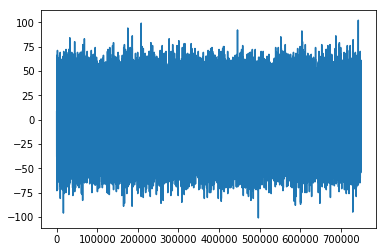

In [83]:
silence3_raw = wav_read('datasets/random-withsilence.wav')
silence3 = silence3_raw[:750000]

silence3_stats = stats(silence3)
for stat in silence3_stats:
    print(f'{stat} = {silence3_stats[stat]}')
plt.plot(silence3)
plt.show()

#### Test 4 - Silence followed by typing "hello "

length = 500000
mean = -0.487918
median = -1.0
max = 52
min = -86
std deviation = 10.10494087193369


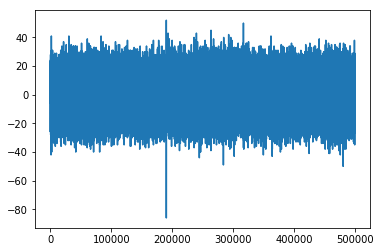

In [113]:
silence4_raw = wav_read('datasets/hello_.wav')
silence4 = silence4_raw[:500000]

silence4_stats = stats(silence4)
for stat in silence4_stats:
    print(f'{stat} = {silence4_stats[stat]}')
plt.plot(silence4)
plt.show()

#### Results

In [133]:
results = pd.DataFrame([silence1_stats, silence2_stats, silence3_stats, silence4_stats], 
                       index=['Test 1', 'Test 2', 'Test 3', 'Test 4'])
results

,length,max,mean,median,min,std deviation
Test 1,300000,104,-0.464423,0.0,-104,22.414488
Test 2,600000,116,-0.462460,0.0,-121,24.353048
Test 3,750000,102,-0.473509,-1.0,-101,20.254398
Test 4,500000,52,-0.487918,-1.0,-86,10.104941


The recording software (GarageBand) samples wav values relative to the entire recording. For example, recording *just* silence results in large values during the silence compared to a recording of silence followed by a keystroke. Test 2 having a greater range and standard deviation can probably be attributed to the fact that the key pressed was "a", as opposed to the much louder "spacebar" and "random" in Tests 1 and 3. In Test 4, the microphone was placed on the table as opposed to near my mouth, which likely contributed to cleaner data.

### Sound preprocessing before keystroke extraction (maybe unnecessary)

In [203]:
def silence_threshold(sound_data, n):
    """Return the silence threshold of the sound data.
    The sound data should begin with n-seconds of silence.
    """
    sampling_rate = 44100
    num_samples   = sampling_rate * n
    silence       = sound_data[:num_samples]
    tolerance     = 40
    if np.std(silence) > tolerance:
        raise Exception(f'Sound data must begin with at least {n}s of silence.')
    else:
        return max(np.amax(silence), abs(np.amin(silence))) * 2

def remove_random_noise(sound_data):
    """Remove random noise from sound data."""
    threshold = silence_threshold(sound_data, 5)
    sound_data_copy = sound_data[:]
    for i in range(len(sound_data_copy)):
        if abs(sound_data_copy[i]) < threshold:
            sound_data_copy[i] = 0
    return sound_data_copy

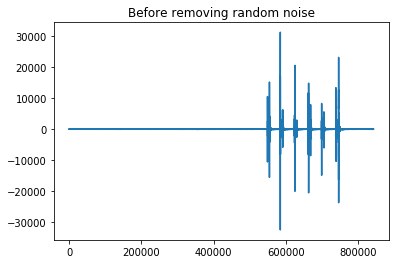

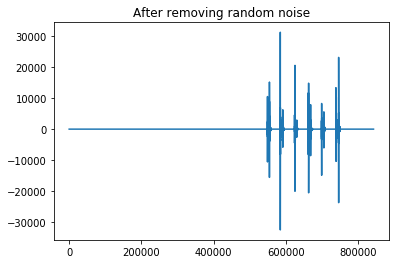

In [204]:
unprocessed_data = wav_read('datasets/hello_.wav')
plt.plot(unprocessed_data)
plt.title('Before removing random noise')
plt.show()

processed_data = remove_random_noise(unprocessed_data)
plt.plot(processed_data)
plt.title('After removing random noise')
plt.show()

### Extracting keystrokes

In [235]:
def extract_keystrokes(sound_data):
    """Return array of arrays denoting each keystroke detected in the sound_data.
    
    Each keystroke consists of a push peak (touch peak and hit peak) and a release peak.
    Returned keystrokes can be varying lengths.
    
    :type sound_file  -- NumPy array denoting input sound clip
    :type sample_rate -- integer denoting sample rate (samples per second)
    :rtype            -- NumPy array of NumPy arrays
    """
    threshold          = silence_threshold(sound_data, 5)
    keystroke_duration = 0.3  # seconds (initial guess)
    sample_rate        = 44100 # Hz
    sample_length      = int(sample_rate * keystroke_duration)
    
    keystrokes = []
    i = 0
    while i < len(sound_data):
        if abs(sound_data[i]) > threshold:
            sample_start, sample_end = i, i + sample_length
            if sample_end <= len(sound_data) and abs(sound_data[sample_end]) > threshold:
                j = sample_end
                while sound_data[j] > threshold:
                    j -= 1
                sample_end = j
            keystroke = sound_data[sample_start:sample_end]
            trailing_zeros = np.array([0 for _ in range(sample_length - (sample_end - sample_start))])
            keystroke = np.concatenate((keystroke, trailing_zeros))
            keystrokes.append(keystroke)
            i = sample_end - 1
        i += 1
    return np.array(keystrokes)

#### Testing

In [242]:
def test_extract_keystrokes(data, expect):
    """Test if extract_keystrokes() extracts the correct number of keystrokes."""
    keystrokes = extract_keystrokes(data)
    actual = len(keystrokes)
    assert expect == actual, f"Detected keystrokes mismatch. Found {actual} instead of {expect}."
    print("Number of keystrokes matched!")
    
    
def run_extract_keystrokes_tests(test_set):
    for filename in test_set:
        wav_file = wav_read(filename)
        expected = test_set[filename]
        test_extract_keystrokes(wav_file, expected)
        
        
test_set = {
    'datasets/hello_.wav': 6,
    'datasets/spacebar-1x-withsilence.wav': 1,
    'datasets/a-16x-withsilence.wav': 16,
}

run_extract_keystrokes_tests(test_set)

Number of keystrokes matched!
Number of keystrokes matched!


AssertionError: Detected keystrokes mismatch. Found 21 instead of 16.

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


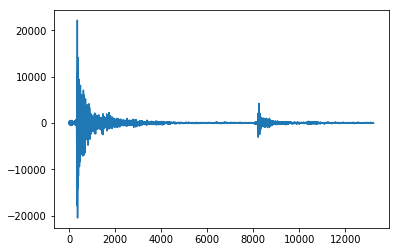

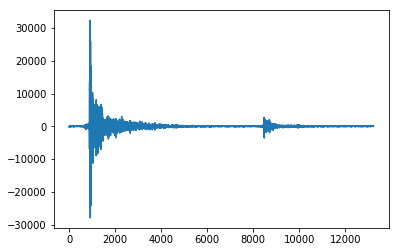

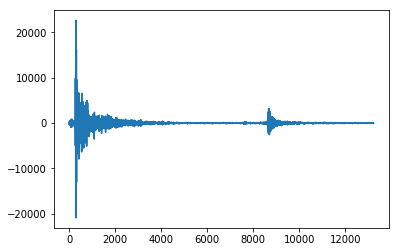

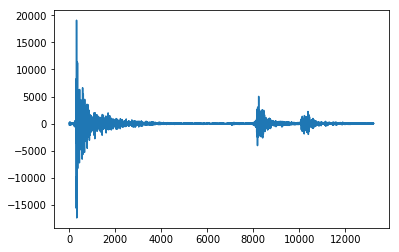

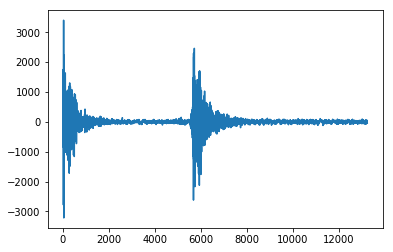

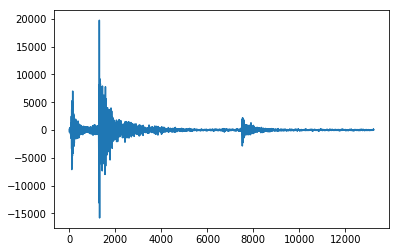

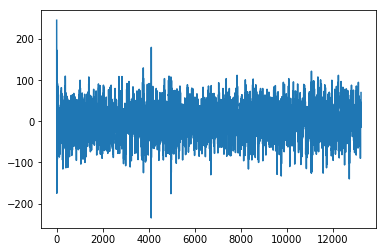

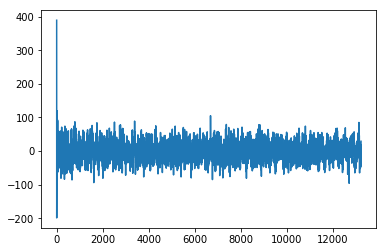

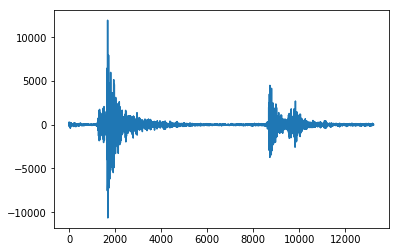

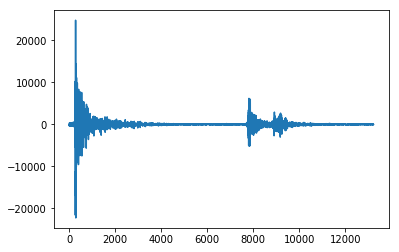

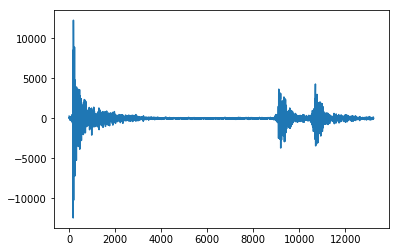

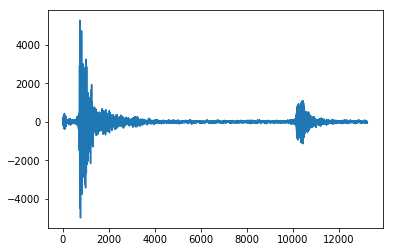

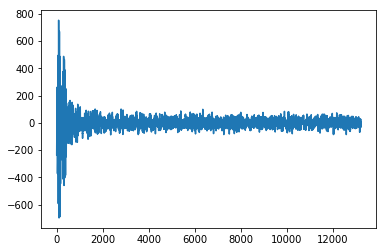

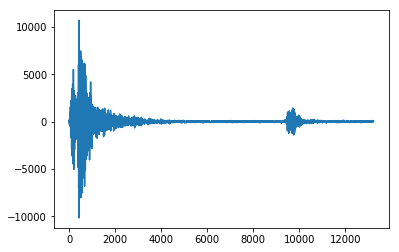

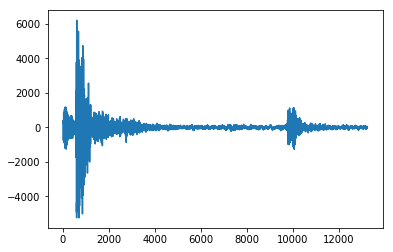

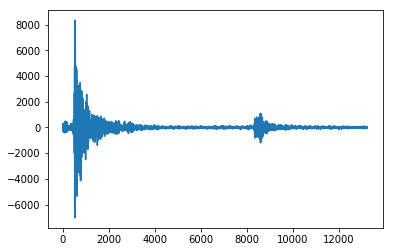

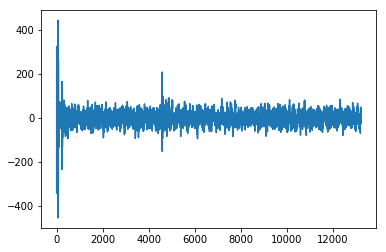

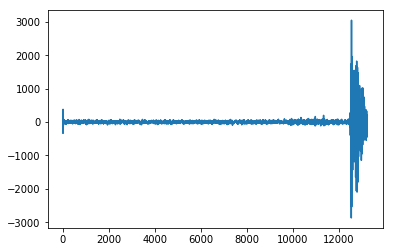

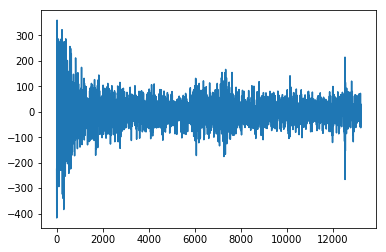

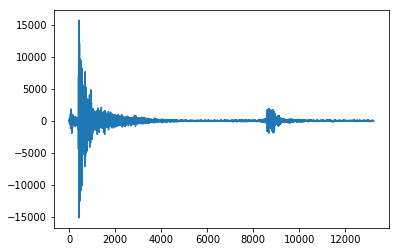

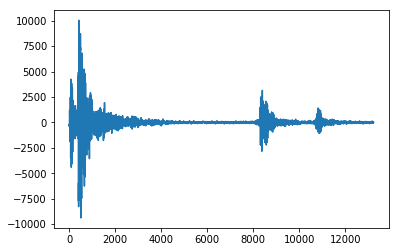

In [243]:
wav_data = wav_read('datasets/a-16x-withsilence.wav')
keystrokes = extract_keystrokes(wav_data)
for keystroke in keystrokes:
    plt.plot(keystroke)
    plt.show()

## Collecting training data

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])